In [24]:
!pip -q install opencv-python scikit-learn matplotlib

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import cv2
from google.colab import files

In [26]:
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.5, color=False)
X = lfw.data             # (n_samples, h*w) flattened images
y = lfw.target           # labels
target_names = lfw.target_names
h, w = lfw.images.shape[1], lfw.images.shape[2]

print("Data shape:", X.shape, "Image shape:", (h, w), "Classes:", len(target_names))


Data shape: (1288, 2914) Image shape: (62, 47) Classes: 7


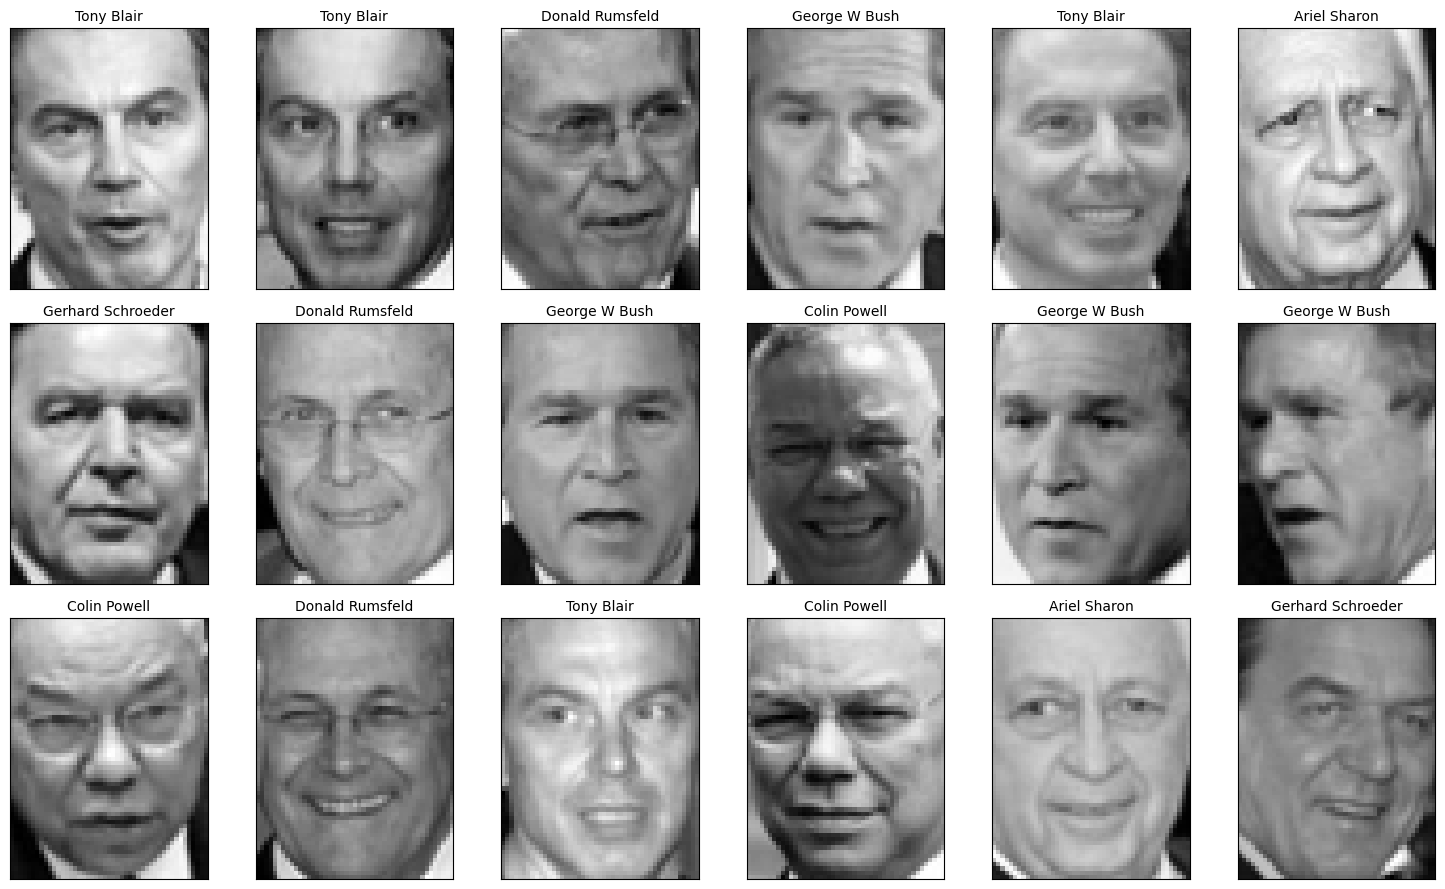

In [27]:
def show_gallery(images, titles=None, h=70, w=70, n_row=3, n_col=6):
    plt.figure(figsize=(2.5*n_col, 3*n_row))
    for i in range(n_row * n_col):
        if i >= images.shape[0]: break
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap="gray")
        plt.xticks([]); plt.yticks([])
        if titles is not None:
            plt.title(titles[i], fontsize=10, wrap = True)
    plt.tight_layout(); plt.show()

indices = np.random.choice(X.shape[0], 18, replace=False)
titles = [target_names[y[i]] for i in indices]
show_gallery(X[indices], titles, h, w)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
X_train.shape, X_test.shape

((966, 2914), (322, 2914))

In [29]:
n_components = 150  # try 50, 100, 150, 300...

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True, random_state=42)
clf = SVC(C=5.0, gamma="scale", kernel="rbf", class_weight="balanced", probability=True, random_state=42)

# Build pipeline: (center) -> PCA -> SVM
model = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=False)),  # center only
    ("pca", pca),
    ("svm", clf)
])

model.fit(X_train, y_train)
print("Done training.")

Done training.


                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.63      0.77        19
     Colin Powell       0.88      0.90      0.89        59
  Donald Rumsfeld       0.86      0.63      0.73        30
    George W Bush       0.77      0.98      0.86       133
Gerhard Schroeder       0.95      0.74      0.83        27
      Hugo Chavez       1.00      0.56      0.71        18
       Tony Blair       1.00      0.81      0.89        36

         accuracy                           0.85       322
        macro avg       0.92      0.75      0.81       322
     weighted avg       0.87      0.85      0.84       322



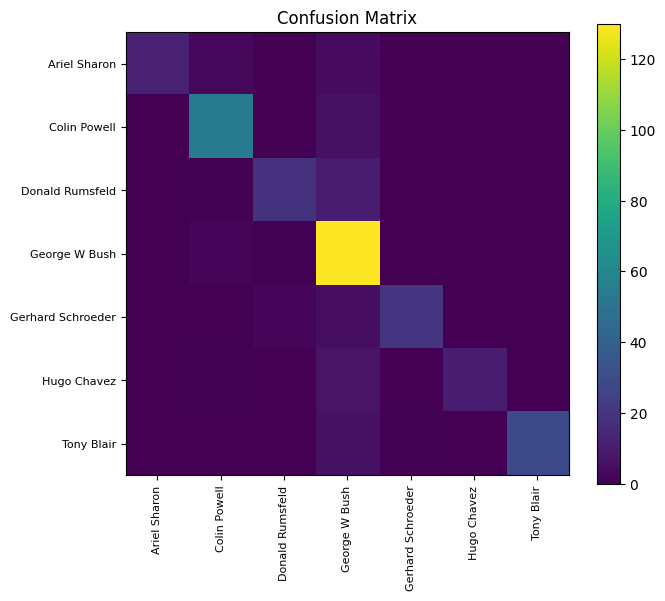

In [30]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(target_names)), target_names, rotation=90, fontsize=8)
plt.yticks(range(len(target_names)), target_names, fontsize=8)
plt.tight_layout()
plt.show()


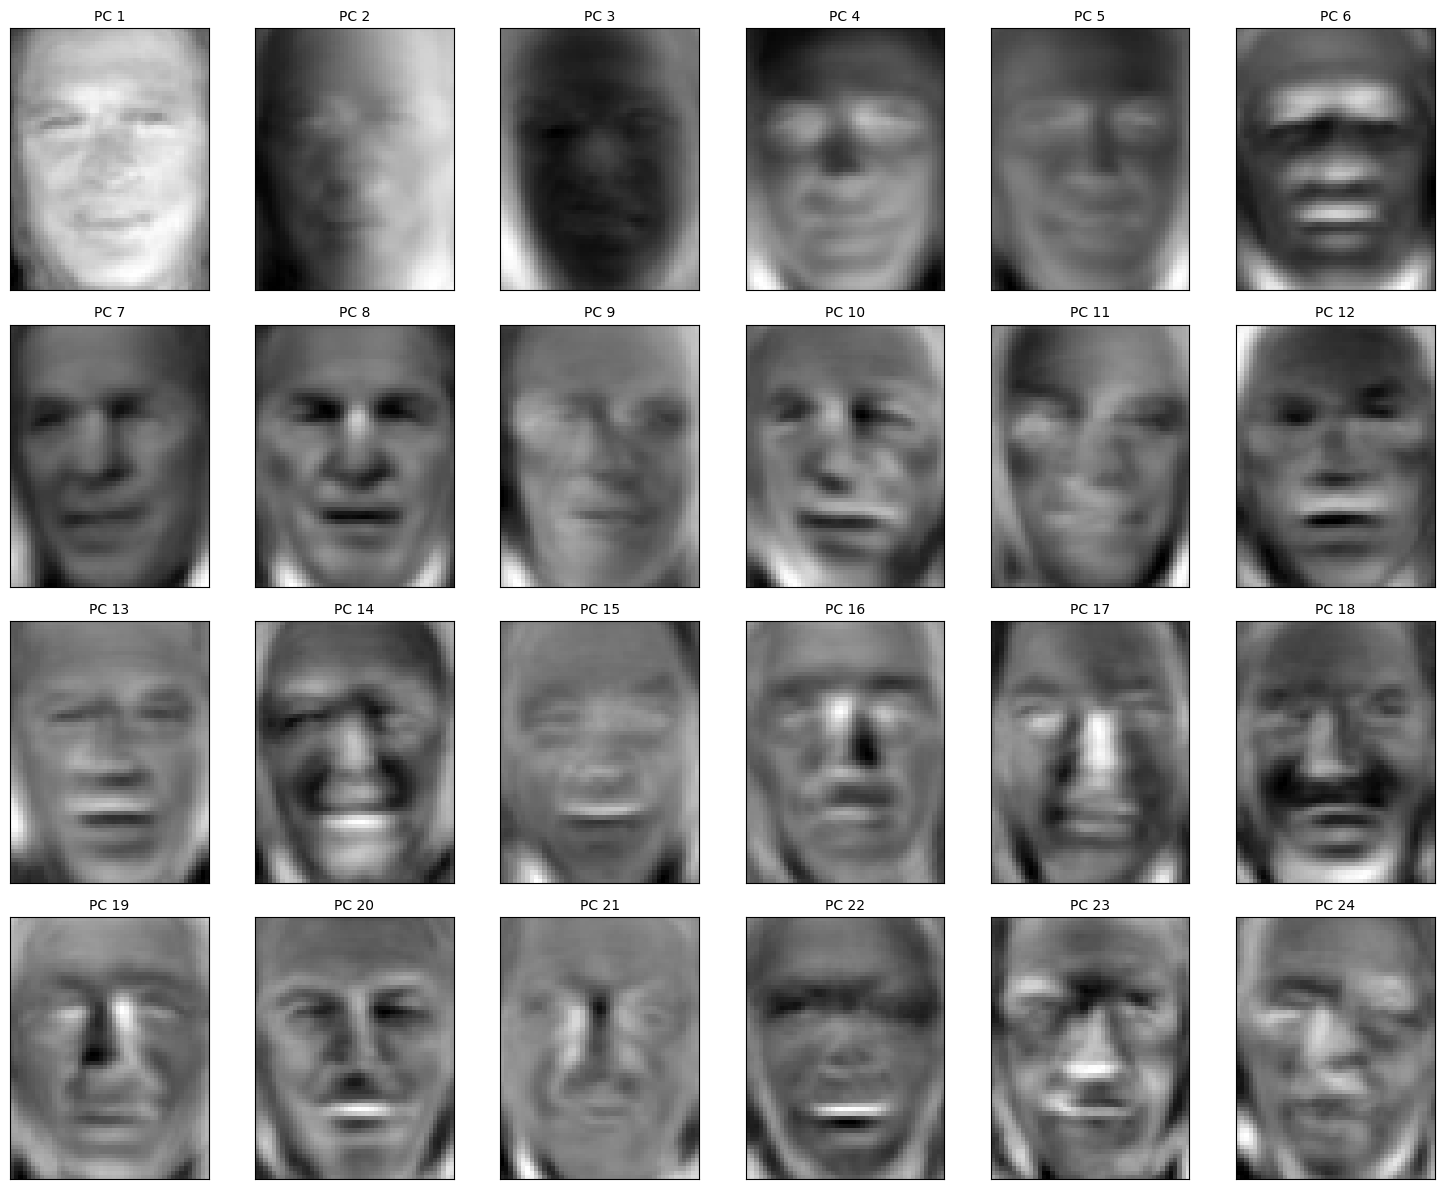

In [31]:
eigenfaces = model.named_steps["pca"].components_.reshape((n_components, h, w))
titles = [f"PC {i+1}" for i in range(n_components)]
show_gallery(eigenfaces[:24], titles[:24], h, w, n_row=4, n_col=6)

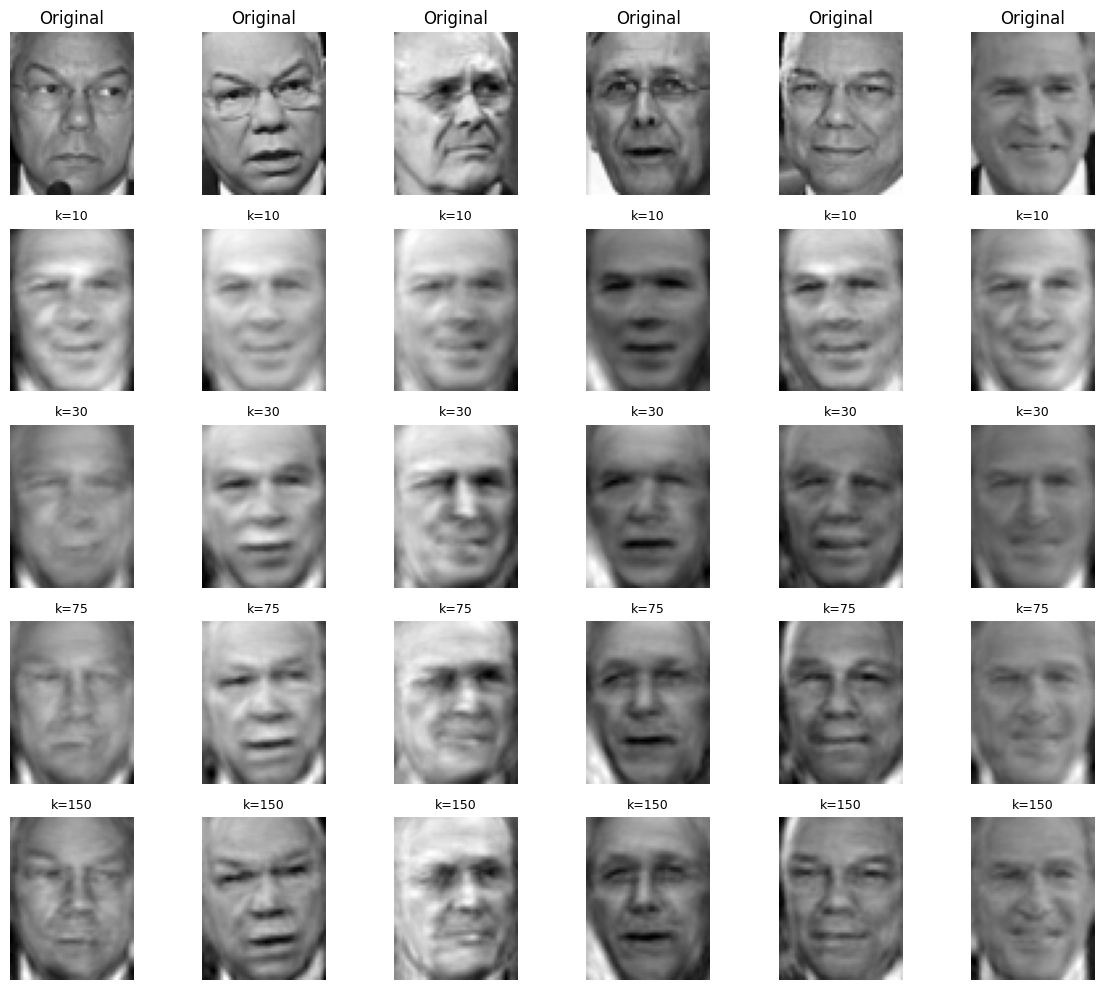

In [32]:
def reconstruct_with_k(X_samples, pca, k, h, w):
    # project to first k components, then back-project
    Wk = pca.components_[:k]                # (k, d)
    Z = (X_samples - pca.mean_) @ Wk.T      # scores in k-dim space
    X_hat = Z @ Wk + pca.mean_              # back to original space
    return X_hat

k_values = [10, 30, 75, 150]
idx = np.random.choice(X_test.shape[0], 6, replace=False)
originals = X_test[idx]

recon_grids = []
for k in k_values:
    X_hat = reconstruct_with_k(originals, model.named_steps["pca"], k, h, w)
    recon_grids.append(X_hat)

# Show originals vs reconstructions
plt.figure(figsize=(12, 10))
rows = 1 + len(k_values)
for i in range(len(idx)):
    # row 0: original
    plt.subplot(rows, len(idx), i+1)
    plt.imshow(originals[i].reshape(h, w), cmap="gray")
    plt.title("Original"); plt.axis("off")

for r, k in enumerate(k_values, start=1):
    for c in range(len(idx)):
        plt.subplot(rows, len(idx), r*len(idx) + c + 1)
        plt.imshow(recon_grids[r-1][c].reshape(h, w), cmap="gray")
        plt.title(f"k={k}", fontsize=9)
        plt.axis("off")
plt.tight_layout(); plt.show()

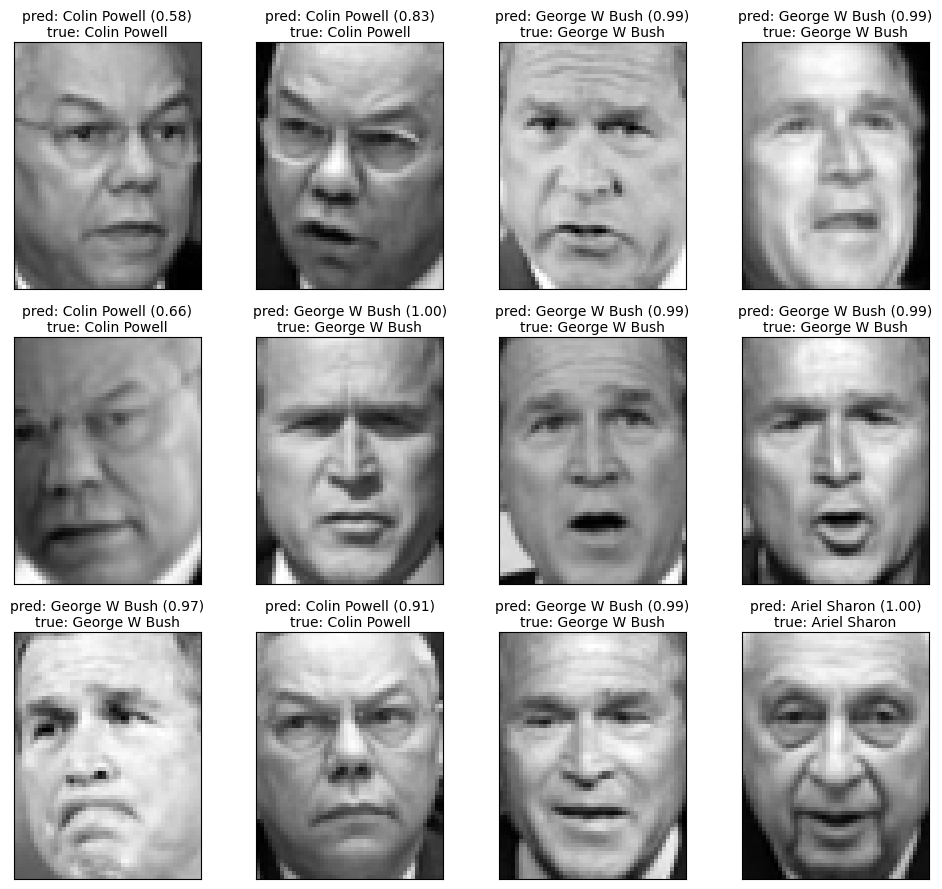

In [33]:
probs = model.predict_proba(X_test[:12])
preds = model.predict(X_test[:12])

titles = [f"pred: {target_names[p]} ({np.max(probs[i]):.2f})\ntrue: {target_names[y_test[i]]}"
          for i, p in enumerate(preds)]
show_gallery(X_test[:12], titles, h, w, n_row=3, n_col=4)